In [1]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shap
import torch
import torch.nn as nn
import collections
import torch.utils.data as data

In [2]:
df = pd.read_csv('SBAnational.csv')
df.head()

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [3]:
bad_columns = ['LoanNr_ChkDgt', 'NAICS', 'ApprovalDate', 'DisbursementDate', 'Name', 'FranchiseCode']
target = 'MIS_Status'
categorical = ['City', 'State', 'Zip', 'Bank', 'BankState', 'NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc']
ordinal = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob']
money_columns = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
date_col = ['ChgOffDate']

In [4]:
# drop bad columns

df = df.drop(columns=bad_columns)
df.head()

,City,State,Zip,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,1997,84,4,2.0,0,...,0,N,Y,NaN,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,1997,60,2,2.0,0,...,0,N,Y,NaN,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,1997,180,7,1.0,0,...,0,N,N,NaN,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,1997,60,2,1.0,0,...,0,N,Y,NaN,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,1997,240,14,1.0,7,...,0,N,N,NaN,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [5]:
# encode ordinal features
df = df.dropna()
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
for col in ordinal:
    print(col)
    df[col] = pd.to_numeric(df['ApprovalFY'].replace('1976A','1976', regex=False).replace('\d+\-\w+\-\d+|,','', regex=True))
    df[col] = df[col].astype('int32')
    df[col] = encoder.fit_transform(df[col].values.reshape(-1, 1))

df.head()

ApprovalFY
Term
NoEmp
CreateJob
RetainedJob


,City,State,Zip,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
6,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,12.0,12.0,12.0,2.0,12.0,...,0,N,N,24-Jun-91,"$600,000.00",$0.00,CHGOFF,"$208,959.00","$600,000.00","$499,998.00"
36,KINSMAN,OH,44428,CORTLAND SAVINGS & BK. CO.,OH,29.0,29.0,29.0,1.0,29.0,...,0,N,Y,18-Apr-02,"$47,000.00",$0.00,CHGOFF,"$14,084.00","$47,000.00","$37,600.00"
43,EDINBURGH,IN,46124,JPMORGAN CHASE BANK NATL ASSOC,IN,12.0,12.0,12.0,2.0,12.0,...,0,Y,N,4-Oct-89,"$197,485.00",$0.00,CHGOFF,"$44,374.00","$200,000.00","$150,000.00"
58,CLINTON (CENSUS NAME FOR CLINT,ME,4927,WELLS FARGO BANK NATL ASSOC,SD,38.0,38.0,38.0,1.0,38.0,...,1,0,N,26-Jun-14,"$1,350,000.00",$0.00,CHGOFF,"$1,043,508.00","$1,350,000.00","$1,012,500.00"
60,Spring Lake,MI,49417,WELLS FARGO BANK NATL ASSOC,SD,29.0,29.0,29.0,1.0,29.0,...,0,0,N,4-Oct-05,"$25,000.00",$0.00,CHGOFF,"$23,484.00","$25,000.00","$12,500.00"


In [6]:
# scale money columns
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
for c in money_columns:
    df[c] = df[c].replace('\$|,','', regex=True).replace('\(','-', regex=True).replace('\)','', regex=True)
    df[c] = pd.to_numeric(df[c])
    df[c] = scaler.fit_transform(df[c].values.reshape(-1, 1))
    
df.head()

,City,State,Zip,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
6,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,12.0,12.0,12.0,2.0,12.0,...,0,N,N,24-Jun-91,0.137547,0.0,CHGOFF,0.059488,0.171429,0.146543
36,KINSMAN,OH,44428,CORTLAND SAVINGS & BK. CO.,OH,29.0,29.0,29.0,1.0,29.0,...,0,N,Y,18-Apr-02,0.010774,0.0,CHGOFF,0.004010,0.013429,0.011020
43,EDINBURGH,IN,46124,JPMORGAN CHASE BANK NATL ASSOC,IN,12.0,12.0,12.0,2.0,12.0,...,0,Y,N,4-Oct-89,0.045272,0.0,CHGOFF,0.012633,0.057143,0.043963
58,CLINTON (CENSUS NAME FOR CLINT,ME,4927,WELLS FARGO BANK NATL ASSOC,SD,38.0,38.0,38.0,1.0,38.0,...,1,0,N,26-Jun-14,0.309480,0.0,CHGOFF,0.297076,0.385714,0.296751
60,Spring Lake,MI,49417,WELLS FARGO BANK NATL ASSOC,SD,29.0,29.0,29.0,1.0,29.0,...,0,0,N,4-Oct-05,0.005731,0.0,CHGOFF,0.006686,0.007143,0.003664


In [7]:
# label encode categorical features
le = preprocessing.LabelEncoder()
for column_name in categorical:
    df[column_name] = le.fit_transform(df[column_name].astype(str))

df.head()

,City,State,Zip,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
6,13806,31,13367,3400,43,12.0,12.0,12.0,2,12.0,...,0,2,3,24-Jun-91,0.137547,0.0,CHGOFF,0.059488,0.171429,0.146543
36,6729,35,7864,932,36,29.0,29.0,29.0,1,29.0,...,0,2,6,18-Apr-02,0.010774,0.0,CHGOFF,0.004010,0.013429,0.011020
43,3773,15,8285,1991,16,12.0,12.0,12.0,2,12.0,...,0,5,3,4-Oct-89,0.045272,0.0,CHGOFF,0.012633,0.057143,0.043963
58,2311,21,9159,3400,43,38.0,38.0,38.0,1,38.0,...,1,0,3,26-Jun-14,0.309480,0.0,CHGOFF,0.297076,0.385714,0.296751
60,13192,22,9205,3400,43,29.0,29.0,29.0,1,29.0,...,0,0,3,4-Oct-05,0.005731,0.0,CHGOFF,0.006686,0.007143,0.003664


In [8]:
# label encode target value
df[target] = le.fit_transform(df[target].astype(str))
df.head()

,City,State,Zip,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
6,13806,31,13367,3400,43,12.0,12.0,12.0,2,12.0,...,0,2,3,24-Jun-91,0.137547,0.0,0,0.059488,0.171429,0.146543
36,6729,35,7864,932,36,29.0,29.0,29.0,1,29.0,...,0,2,6,18-Apr-02,0.010774,0.0,0,0.004010,0.013429,0.011020
43,3773,15,8285,1991,16,12.0,12.0,12.0,2,12.0,...,0,5,3,4-Oct-89,0.045272,0.0,0,0.012633,0.057143,0.043963
58,2311,21,9159,3400,43,38.0,38.0,38.0,1,38.0,...,1,0,3,26-Jun-14,0.309480,0.0,0,0.297076,0.385714,0.296751
60,13192,22,9205,3400,43,29.0,29.0,29.0,1,29.0,...,0,0,3,4-Oct-05,0.005731,0.0,0,0.006686,0.007143,0.003664


In [9]:
# convert date to ordinal days
for c in date_col:
    df[c] = pd.to_datetime(df[c]).dt.dayofyear

df.head()

,City,State,Zip,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
6,13806,31,13367,3400,43,12.0,12.0,12.0,2,12.0,...,0,2,3,175,0.137547,0.0,0,0.059488,0.171429,0.146543
36,6729,35,7864,932,36,29.0,29.0,29.0,1,29.0,...,0,2,6,108,0.010774,0.0,0,0.004010,0.013429,0.011020
43,3773,15,8285,1991,16,12.0,12.0,12.0,2,12.0,...,0,5,3,277,0.045272,0.0,0,0.012633,0.057143,0.043963
58,2311,21,9159,3400,43,38.0,38.0,38.0,1,38.0,...,1,0,3,177,0.309480,0.0,0,0.297076,0.385714,0.296751
60,13192,22,9205,3400,43,29.0,29.0,29.0,1,29.0,...,0,0,3,277,0.005731,0.0,0,0.006686,0.007143,0.003664


In [10]:
#drop rows with NaN or Inf values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

df.head()

,City,State,Zip,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
6,13806,31,13367,3400,43,12.0,12.0,12.0,2,12.0,...,0,2,3,175,0.137547,0.0,0,0.059488,0.171429,0.146543
36,6729,35,7864,932,36,29.0,29.0,29.0,1,29.0,...,0,2,6,108,0.010774,0.0,0,0.004010,0.013429,0.011020
43,3773,15,8285,1991,16,12.0,12.0,12.0,2,12.0,...,0,5,3,277,0.045272,0.0,0,0.012633,0.057143,0.043963
58,2311,21,9159,3400,43,38.0,38.0,38.0,1,38.0,...,1,0,3,177,0.309480,0.0,0,0.297076,0.385714,0.296751
60,13192,22,9205,3400,43,29.0,29.0,29.0,1,29.0,...,0,0,3,277,0.005731,0.0,0,0.006686,0.007143,0.003664


In [11]:
df.head()

,City,State,Zip,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
6,13806,31,13367,3400,43,12.0,12.0,12.0,2,12.0,...,0,2,3,175,0.137547,0.0,0,0.059488,0.171429,0.146543
36,6729,35,7864,932,36,29.0,29.0,29.0,1,29.0,...,0,2,6,108,0.010774,0.0,0,0.004010,0.013429,0.011020
43,3773,15,8285,1991,16,12.0,12.0,12.0,2,12.0,...,0,5,3,277,0.045272,0.0,0,0.012633,0.057143,0.043963
58,2311,21,9159,3400,43,38.0,38.0,38.0,1,38.0,...,1,0,3,177,0.309480,0.0,0,0.297076,0.385714,0.296751
60,13192,22,9205,3400,43,29.0,29.0,29.0,1,29.0,...,0,0,3,277,0.005731,0.0,0,0.006686,0.007143,0.003664


In [12]:
Y = df[target]
X = df.drop(columns=[target])

# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [13]:
lr = LogisticRegression(random_state=1, max_iter=300, penalty="l2", C=0.1)
lr.fit(X_train, Y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
exp = shap.LinearExplainer(lr, X_train, feature_perturbation="interventional")

In [15]:
shap_values = exp.shap_values(X_test)

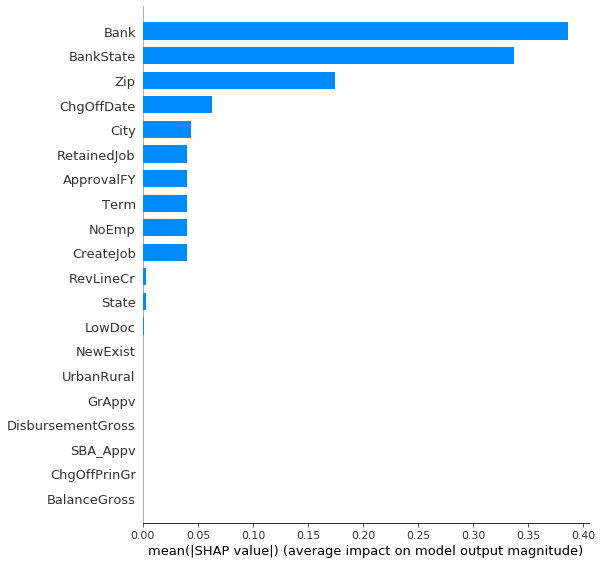

In [22]:
test_exp = X_test
shap.summary_plot(shap_values, test_exp, plot_type="bar")

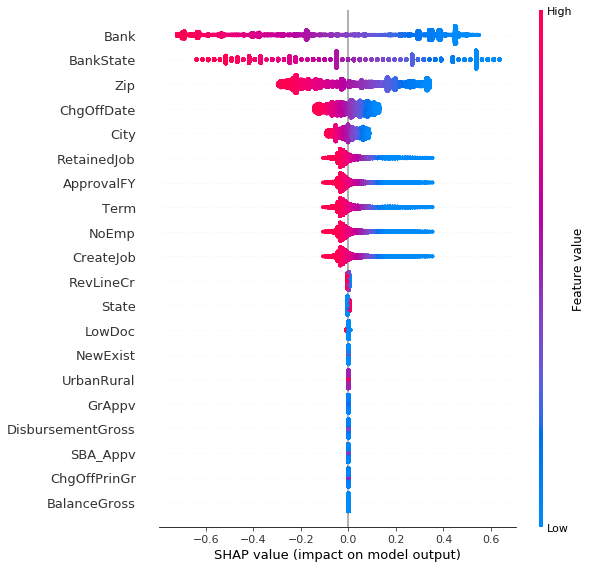

In [19]:
shap.summary_plot(shap_values, X_test)